Przewidywane bedzie PM 10 - mieszanina zawieszonych w powietrzu cząsteczek, których średnica nie przekracza 10 mikrometrów. Jest szkodliwy z uwagi na zawartość takich elementów jak benzopireny, furany, dioksyny – jednym słowem, rakotwórcze metale ciężkie.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import KNNImputer, SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

In [2]:
df = pd.read_csv('../Data_for_ML/LOCFnB_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
df.columns[df.isna().mean() > 0]

Index([], dtype='object')

In [3]:
df = pd.read_csv('../Data_for_ML/kNN_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
df.columns[df.isna().mean() > 0]

Index([], dtype='object')

In [4]:
df = pd.read_csv('../Data_for_ML/Mean_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
df.columns[df.isna().mean() > 0]

Index([], dtype='object')

In [5]:
df = pd.read_csv('../Data_for_ML/Linear_interpolation_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
df.columns[df.isna().mean() > 0]

Index([], dtype='object')

$\textbf{Date Component Features} \\$
Let's prepare dataset by enhancing it with useful features and separating it into training/testing splits.

In [6]:
def create_date_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [7]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_date_features(df)

Let's see if enhancing dataset gives anything worthy. One effective way is through boxplots. Let's for example check the air quality through the date_features.

In [8]:
def plot_by_datetime(feature, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(15, 5))
        sns.boxplot(data=df, x=time_group, y=feature, palette="icefire", showfliers=False)
        ax.set_title(f'{feature} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

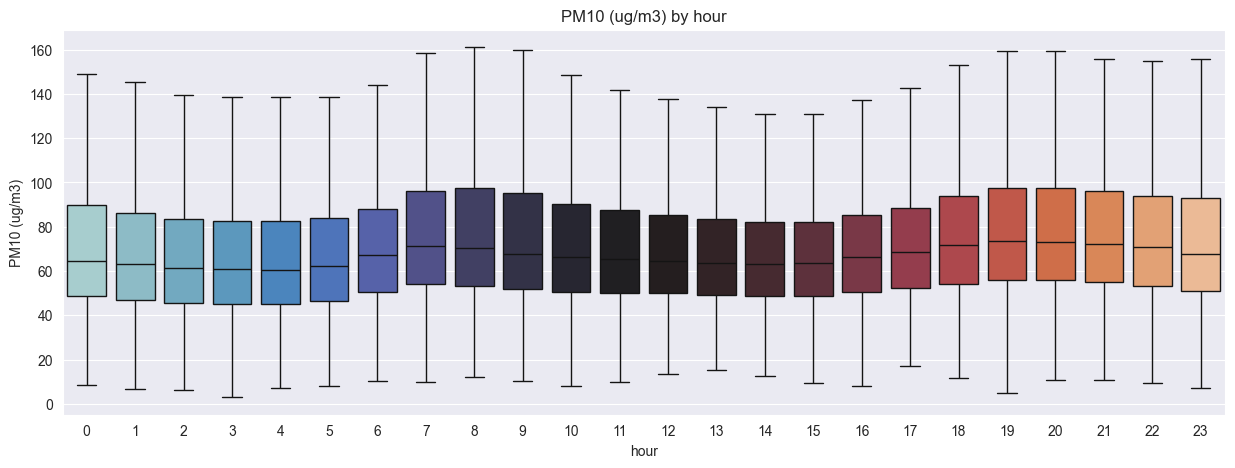

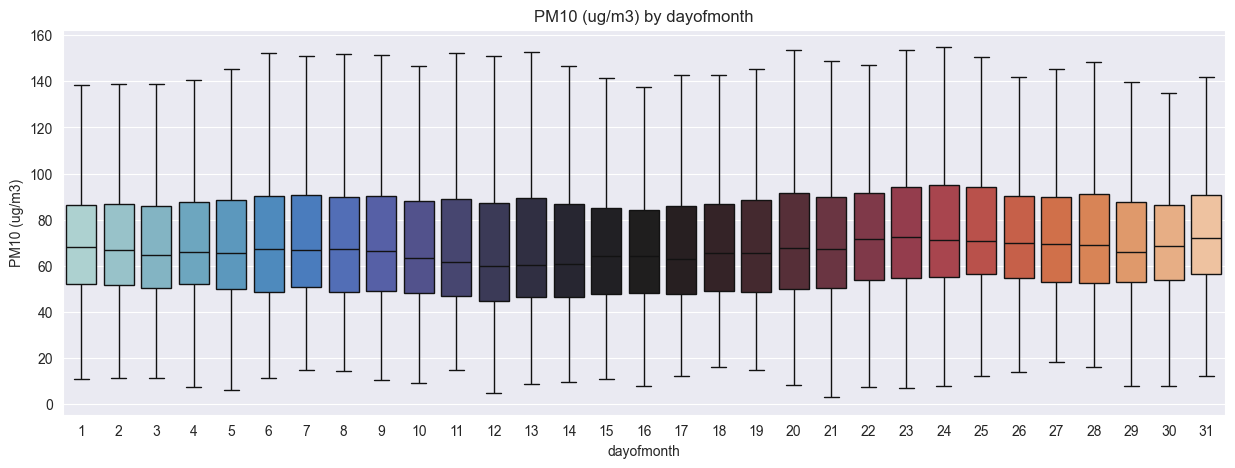

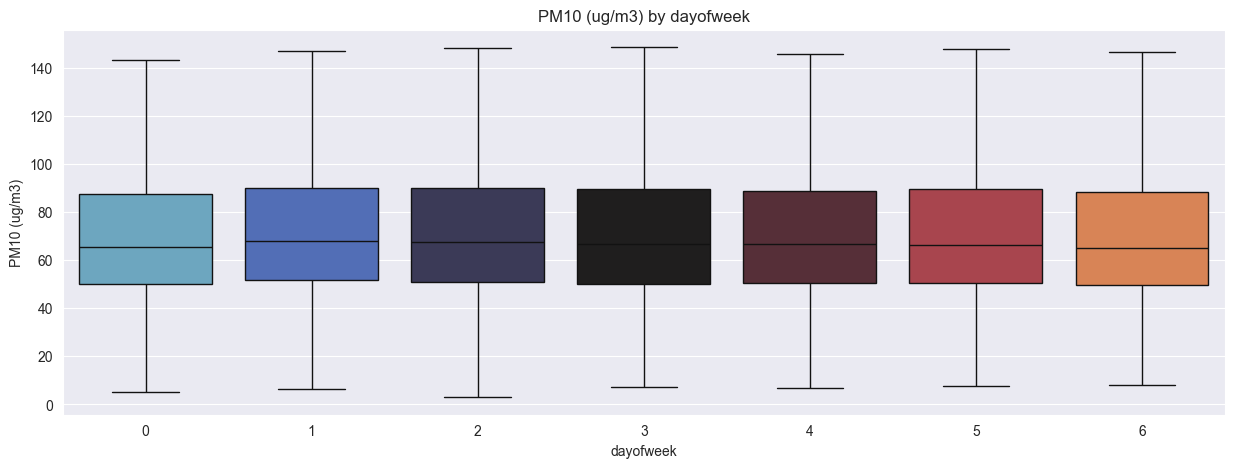

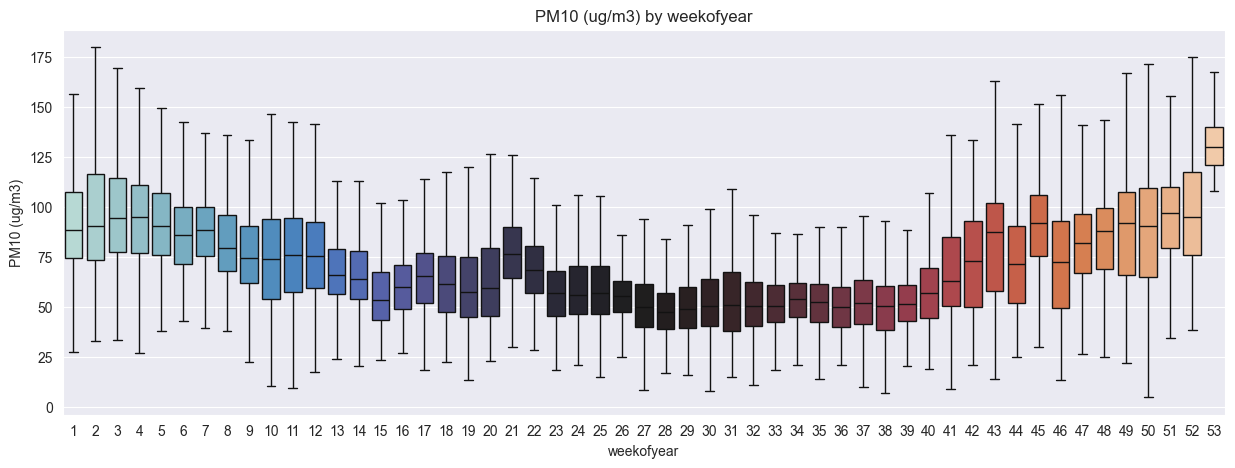

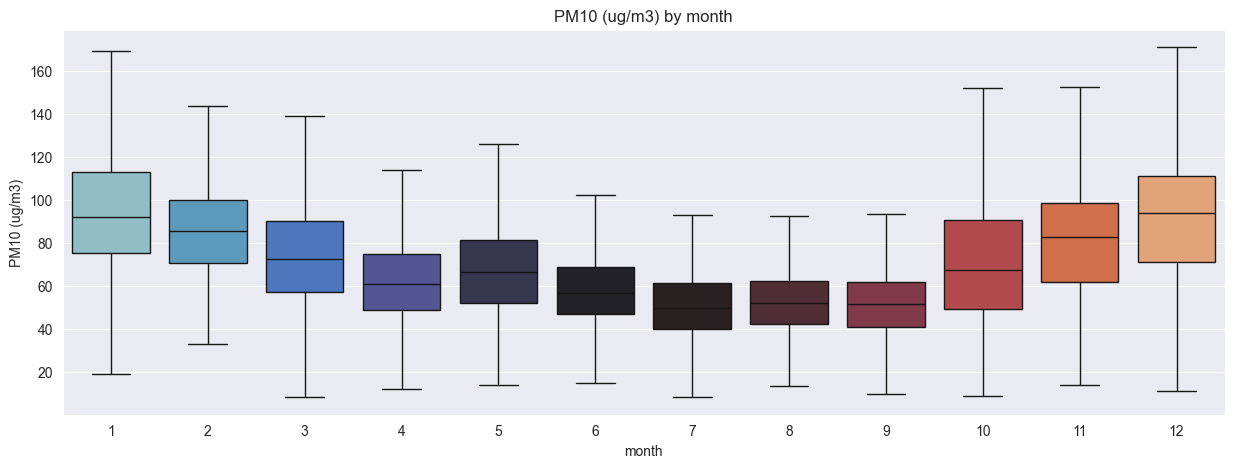

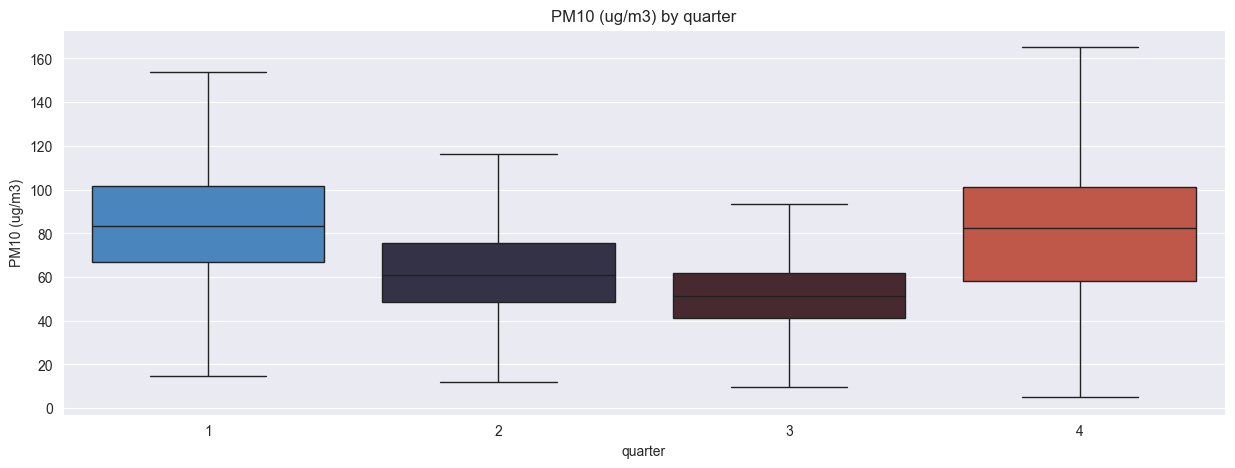

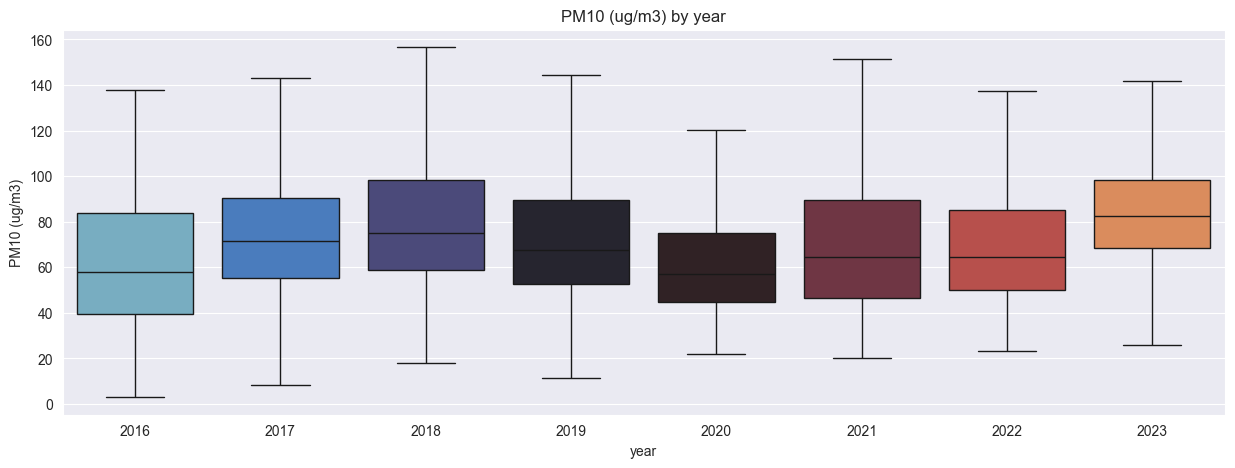

In [9]:
feature = 'PM10 (ug/m3)'
time_feature = ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year']
plot_by_datetime(feature= feature, time_groups= time_feature)

These plots demonstrate that the different datetime groups effectively capture significant trends and information. Interestingly, the 'dayofweek' and 'dayofmonth' features vector might not be as crucial, since the distribution appears quite similar across all range. Nonetheless, we will include all this additional information in our model.

$\textbf{Note} \\ $
Lag features capture information about a variable in a prior time step. In the case of forecasting, such lag features are likely to be predictive and help our models. What's more, I can also include lag features based on other predictive features in order to improve the forecasting accuracy. 

My dataset is too small to perform such a procedure. Therefore, I would have to remove data with empty rows for this feature to avoid issues during model training, which could lead to losing some valuable data.

$\textbf{Time Series Forecasting} \\ $
I will perform time series forecasting based on our extended analysis. I am going to compare various well known models, and present the results.
This part will be divided into 3 parts:

1. Machine Learning Models

2. Deep Learining Model

3. Armia Model

In [10]:
# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV
)

import time                        # time processing
import xgboost as xgb                       # Extreme Gradient Boosting library

# How many cores to use. Put -1 to use all cores.
N_JOBS = -1

# Random variable for having consistent results between runs
RANDOM_STATE = 18

In [11]:
target_feature = feature
predictors = df.columns.to_list()
predictors.remove(target_feature)

print(target_feature, end= '\n\n')
print(predictors)

PM10 (ug/m3)

['NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)', 'WD (degree)', 'hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']


In [12]:
def train_test_split(df: pd.DataFrame, split: float, predictors: list, target: str):
    """
    Splits a DataFrame into training and testing sets based on a specified split ratio.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be split.
    split (float): The fraction of data to be used for the training set (e.g., 0.8 for 80% training data).
    predictors (list): A list of column names to be used as predictors/features.
    target (str): The column name of the target variable.

    Returns:
    tuple: A tuple containing:
        - train_predictors (pd.DataFrame): The training set predictors.
        - train_target (pd.Series): The training set target.
        - test_predictors (pd.DataFrame): The testing set predictors.
        - test_target (pd.Series): The testing set target.
    """
    
    # Create a copy of the input DataFrame to avoid modifying the original data
    dataframe = df.copy()

    # Calculate the index at which to split the DataFrame
    split_index = int(dataframe.__len__() * split)

    # Split the DataFrame into training and testing sets
    train, test = dataframe.iloc[:split_index, :], dataframe.iloc[split_index:, :]

    # Return the specified columns (predictors and target) for both training and testing sets
    return train[predictors], train[target], test[predictors], test[target]


In [13]:
train_x, train_y, test_x, test_y  = train_test_split(df, split = .8, predictors= predictors, target= target_feature)

In [14]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape 

((47320, 25), (47320,), (11830, 25), (11830,))

$\textbf{1st - ML Models}$

In [15]:
models = {
    'Random Forest':     RandomForestRegressor(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost':           xgb.XGBRegressor(random_state=RANDOM_STATE)
}

To determine the best model, I will use various metrics to evaluate their performance. Specifically, I will utilize the following:

1. **R² (Coefficient of Determination):**
   - Evaluates how effectively a model predicts the dependent variable. Ranges from 0 to 1, where 1 indicates perfect prediction. If R²_test is much less than R²_train, it suggests poor generalization to new data. (Higher values are better)

2. **Root Mean Squared Error (RMSE):**
   - Measures the spread of residuals (prediction errors) by calculating the square root of their average squared differences. Both RMSE and MSE (Mean Squared Error) penalize larger errors more heavily. (Lower values are better)

3. **Mean Absolute Error (MAE):**
   - Calculates the average absolute difference between actual and predicted values. Less sensitive to outliers compared to RMSE, as it does not penalize large errors as heavily. (Lower values are better)


In [16]:
def model_scorces(models):
    '''
    Uses various metric algorithms to calculate various scores for multiple estimators
    '''
    metrics = []

    for model_name, model in models.items():            
        model.fit(train_x, train_y)
        predictions_test = model.predict(test_x)
        
        metrics.append([
            model_name,
            model.score(train_x, train_y),
            r2_score(test_y, predictions_test),
            np.sqrt(mean_squared_error(test_y, predictions_test)),
            mean_absolute_error(test_y, predictions_test)
        ])
    
    return pd.DataFrame(metrics, columns=['model', 'R2_train', 'R2_test', 'RMSE', 'MAE'])

In [17]:
prediction_scores = model_scorces(models)
prediction_scores

,model,R2_train,R2_test,RMSE,MAE
0,Random Forest,0.976537,0.521704,16.814266,13.014572
1,Gradient Boosting,0.709487,0.548067,16.344313,12.524968
2,XGBoost,0.897155,0.450794,18.017620,13.862682


In [18]:
def plot_estimator_scores(scores):
    r2_melt = scores[['model', 'R2_train', 'R2_test']].rename(columns={"R2_train": "train", "R2_test": "test"})
    r2_melt = r2_melt.melt(id_vars= ['model'], value_vars= ['train', 'test'], value_name= 'score', var_name= 'set')

    fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize = (15,9))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.4)

    sns.barplot(data=r2_melt.round(2), x='score', y='model', hue='set', orient='h', ax=axes[0,0])
    sns.barplot(data=scores.round(2), x='RMSE', y='model', orient='h', ax=axes[0,1] , hue= 'model')
    sns.barplot(data=scores.round(2), x='MAE', y='model', orient='h', ax=axes[1,0] , hue= 'model')
    
    axes[0,0].set_title('R2 Score')
    for i in range(2):
        axes[0,0].bar_label(axes[0,0].containers[i], size=15, padding=5)
    
    axes[0,0].set(xlabel=None, ylabel=None)
    axes[0,0].set_xlim(0, max(r2_melt['score'])*1.4)

    axes[0,1].set_title('Root Mean Squared Error')
    for i in range(3):
        axes[0,1].bar_label(axes[0,1].containers[i], size=15, padding=5)
    
    axes[0,1].set(xlabel=None, ylabel=None)
    axes[0,1].set_xlim(0, max(scores['RMSE'])*1.4)
    
    axes[1,0].set_title('Mean Absolute Error')
    for i in range(3):
        axes[1,0].bar_label(axes[1,0].containers[i], size=15, padding=5)
    
    axes[1,0].set(xlabel=None, ylabel=None)
    axes[1,0].set_xlim(0, max(scores['MAE'])*1.4)
    
    plt.show()

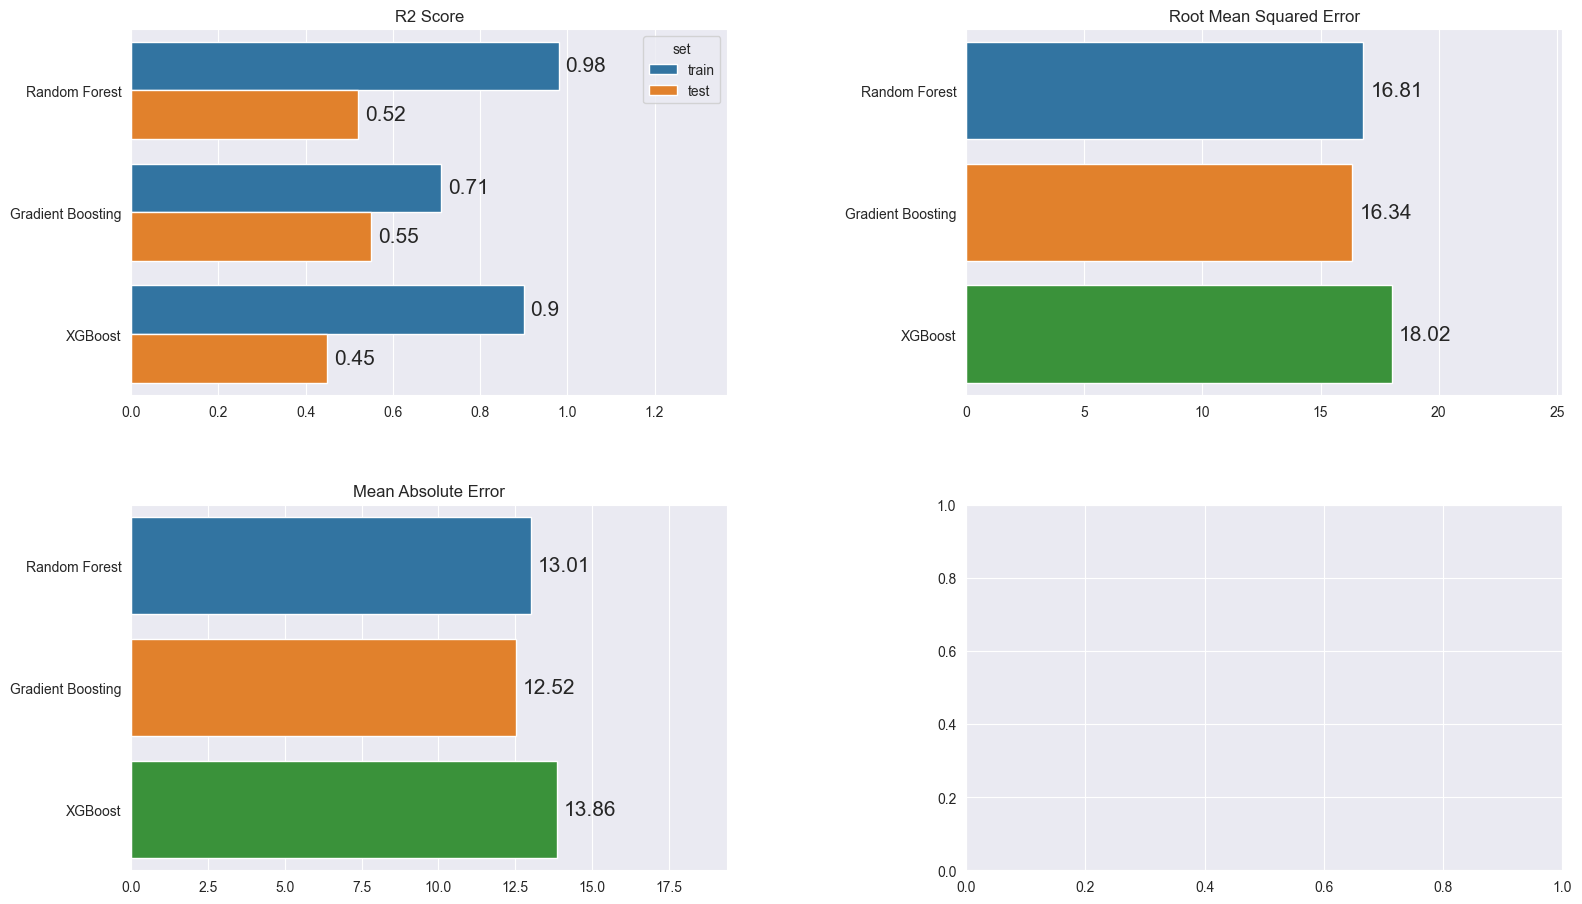

In [19]:
plot_estimator_scores(prediction_scores)

$\textbf{Cross-Validation} \\$

Cross-validation is a method employed in machine learning to assess the predictive performance of models. During each iteration, the algorithm partitions the input data into two segments: a training set and a validation set (folds). The model is trained on the training set and then evaluated on the validation set. This approach helps gauge how accurately a model can predict and generalize to unseen data.

In this scenario, I am analyzing time series data where records are arranged chronologically. Randomly dividing such data into folds may not be suitable because my goal is to forecast future values. Instead, I utilize a specialized cross-validation technique called TimeSeriesSplit. This method segments the time series into fixed intervals for training and testing. Each segment progresses forward in time, ensuring that each subsequent set includes records from a later time period than the previous one.

Let's visualize the resulting splits for our test dataset.



In [20]:
time_series_cv = TimeSeriesSplit(n_splits=5)

This is how data is splited

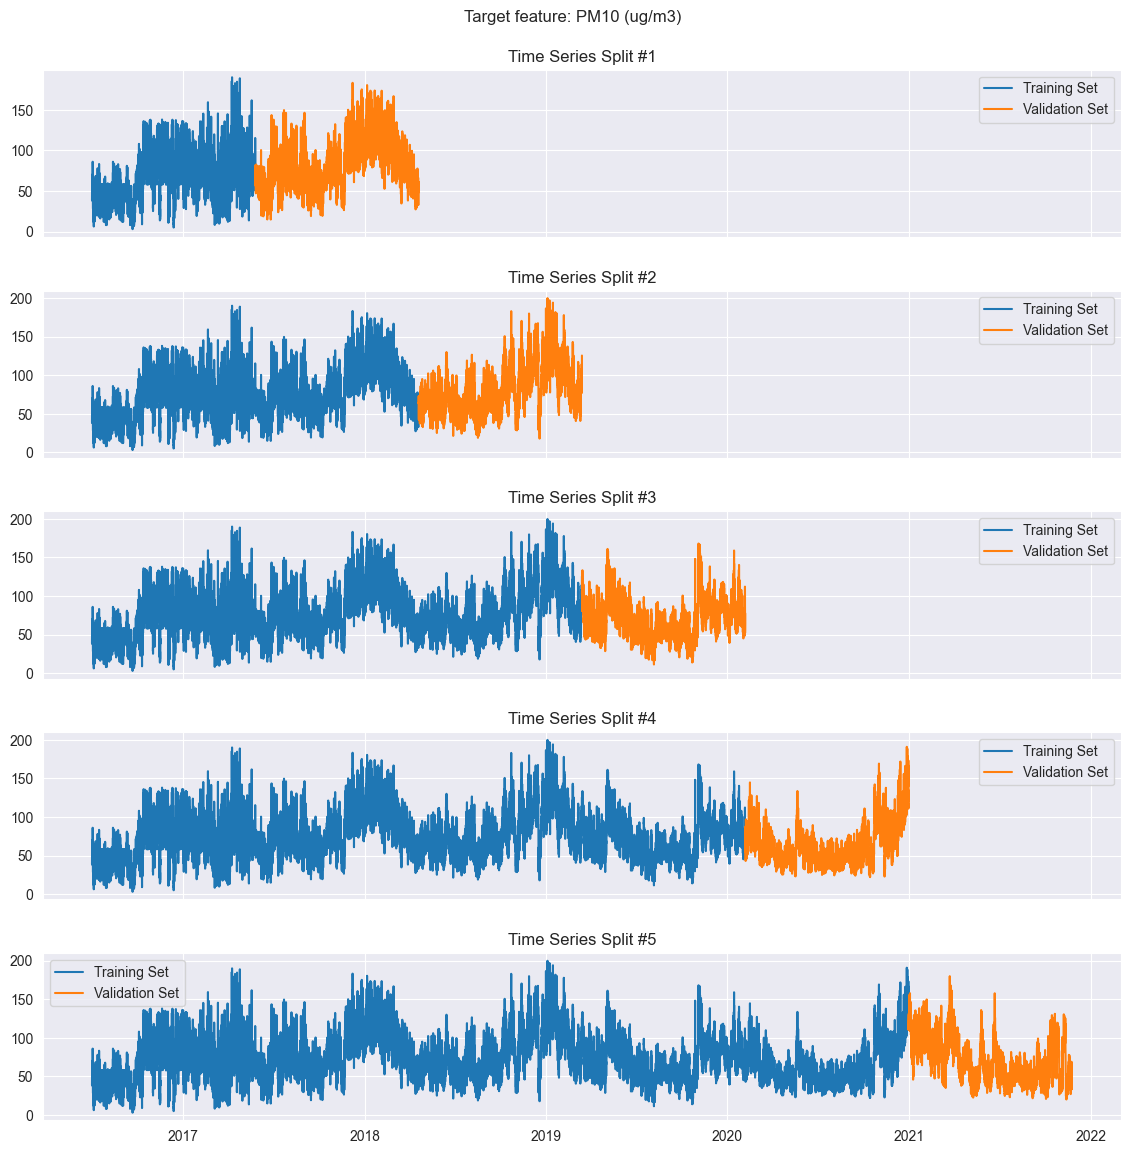

In [21]:
fig, axes = plt.subplots(time_series_cv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.93)

for index, (train_fold, validation_fold) in enumerate(time_series_cv.split(train_y)):
    sns.lineplot(data=train_y.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=train_y.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index + 1}')
    axes[index].set(xlabel=None, ylabel=None)

fig.suptitle(f'Target feature: {target_feature}')    
plt.show()

Now I will perform cross-validation for all our models and share the score.

In [22]:
def get_cross_val_scores(models, x, y, cv, scoring):
    '''
    Get cross validated scores for input models.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and the estimator object.
        x (DataFrame): A DataFrame containing the feature values to train upon.
        y (DataFrame): A Series object containing the actual predicted values.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        results (DataFrame): A DataFrame which contains the results for the CV run.
    '''
    
    measurements = [(model_name, i, score)
                    for model_name, model in models.items()
                    for i, score in enumerate(-cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=N_JOBS))]

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

In [23]:
cv_results = get_cross_val_scores(models, train_x, train_y, cv=time_series_cv, scoring='neg_root_mean_squared_error')

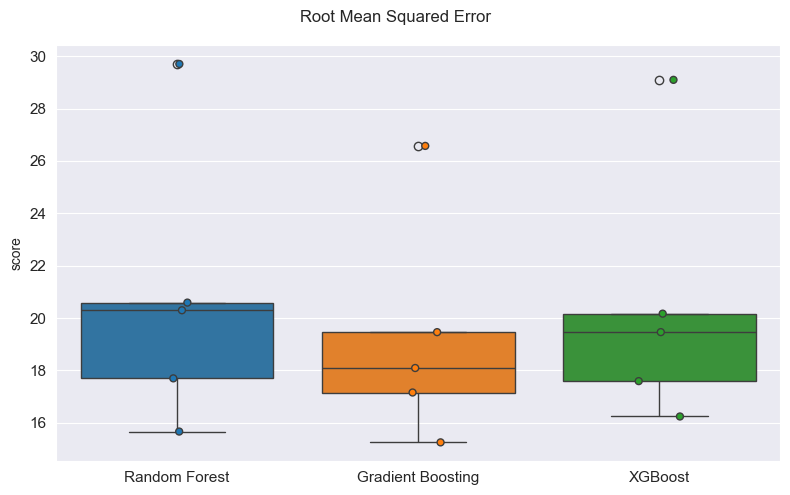

In [24]:
plt.figure(figsize=(8,5))
plt.suptitle('Root Mean Squared Error')

cv_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results, hue='model')
cv_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=5, jitter=True, linewidth=1, legend=False)

cv_metrics_bxplt.tick_params(labelsize=11)
cv_metrics_bxplt.set(xlabel=None)
plt.tight_layout()
plt.show()

In [25]:
cv_results.groupby('model').score.mean().sort_values()

model
Gradient Boosting    19.306859
XGBoost              20.511604
Random Forest        20.790220
Name: score, dtype: float64

$\textbf{Hyperparameter Tuning} \\$

To achieve an optimal model architecture, we need to make several design choices, which come in the form of parameters known as hyperparameters. Unlike other parameters, these values are not automatically learned by the model and must be manually adjusted. Since we may not know the best hyperparameters in advance, we need to explore a wide range of possibilities. Therefore, we define a mapping of hyperparameters and specify the search space we wish to investigate.

Two popular methods for hyperparameter tuning are GridSearch and RandomSearch. GridSearch exhaustively explores every possible combination of hyperparameters, ensuring the best result but at the expense of being extremely slow. RandomSearch, on the other hand, selects random subsets of the search space, making it faster and often providing satisfactory results. For this notebook, I will use RandomSearch.



In [26]:
# Hyperparameter configurations for RandomizedSearch
model_hyperparameters = {
    'Random Forest': {'n_estimators': [50, 100, 150, 200],
                      'min_samples_split': [2, 4, 5],
                      'min_samples_leaf': [2, 4, 6, 8, 10],
                      'max_depth': [5, 10, 15],
                      'n_jobs': [N_JOBS],
                      'random_state': [RANDOM_STATE]},
    
    'Gradient Boosting': {'learning_rate': np.arange(0.001, 1, 0.01),
                          'n_estimators': [100, 200, 300],
                          'min_samples_split': [2, 4, 5],
                          'min_samples_leaf': [2, 4, 6, 8, 10],
                          'max_depth': [5, 10, 15],
                          'n_iter_no_change': [10],
                          'tol': [0.01],
                          'random_state': [RANDOM_STATE]},
    
    'XGBoost': {'learning_rate': np.arange(0.001, 1, 0.01),
                'n_estimators': [20, 50, 100, 250],
                'max_depth': [None, 3, 5, 8],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [N_JOBS],
                'random_state': [RANDOM_STATE]}
}

In [27]:
def random_search_cv(models, params, n_iter, cv, scoring):
    '''
    Performs hyperparameter tuning using RandomizedSearch.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and its respective estimator object.
        params (dict): Dictionary containing the name of the model and its respective hyperparameter spaces to search.
        n_iter (int): The number of candidates to choose from the search space.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        models (dict): A dictionary containing the name of the model and the tuned model parameters.
        model_scores (DataFrame): DataFrame indicating the model's name and the attained best score.
    '''
    

    # Print the fitting process information
    print(f'Fitting {cv.n_splits} folds for each of {n_iter} candidates, totalling {cv.n_splits * n_iter} fits.\n')
    
    # Initialize an empty list to store the scores of each model
    model_scores = []

    # Loop through each model in the models dictionary
    for model_name, model in models.items():
        start = time.time()  # Record the start time

        # Initialize RandomizedSearchCV for the current model
        # RandomizedSearchCV is used to search through the specified hyperparameter space
        rscv_model = RandomizedSearchCV(model, params[model_name],
                                        cv=cv,
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=N_JOBS,
                                        n_iter=n_iter,
                                        random_state=RANDOM_STATE)

        # Special fitting process for XGBoost
        if model_name == 'XGBoost':
            rscv_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=0)
        else:
            rscv_model.fit(train_x, train_y)

        end = time.time()  # Record the end time

        # Print the completion message with the time taken and the best parameters found
        print(f'Randomized Search CV for {model_name} finished after {round(end - start, 2)} seconds. Best parameters found:')
        print(f'{rscv_model.best_params_}\n')

        # Update the models dictionary with the best estimator
        models[model_name] = rscv_model.best_estimator_
        
        # Append the model name and best score to the model_scores list
        model_scores.append((model_name, round(-rscv_model.best_score_, 4)))
    
    # Convert the model_scores list to a DataFrame
    model_scores = pd.DataFrame(model_scores, columns=['model', 'score'])
    
    return models, model_scores

In [28]:
models, rscv_scores = random_search_cv(models, model_hyperparameters, n_iter= 100, cv=time_series_cv, scoring="neg_root_mean_squared_error")

Fitting 5 folds for each of 100 candidates, totalling 500 fits.

Randomized Search CV for Random Forest finished after 455.9 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 15}

Randomized Search CV for Gradient Boosting finished after 640.41 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.040999999999999995}

Randomized Search CV for XGBoost finished after 17.25 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.28099999999999997, 'eval_metric': 'rmse', 'early_stopping_rounds': 10}



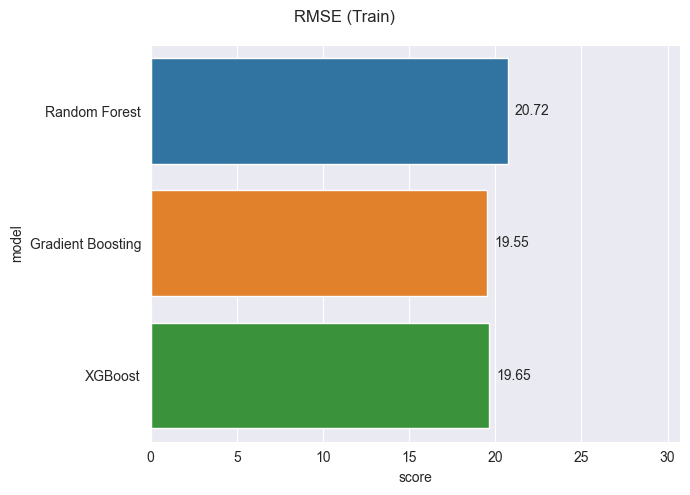

In [37]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("RMSE (Train)")

metrics_plt = sns.barplot(rscv_scores.round(2), x='score', y='model', orient='h', hue= 'model')
metrics_plt.tick_params(labelsize=10)
for i in range(3):
    metrics_plt.bar_label(metrics_plt.containers[i], size=10, padding=5)

plt.xlim(0, max(rscv_scores.score)+10)
plt.tight_layout()
plt.show()

Let's now evaluate the tuned models on their ability to predict unseen data (testing set) and also measure the time needed to train and make predictions.

In [30]:
time_metrics = []
for model_name, model in models.items():
    
    fit_start = time.time()
    if model_name == 'XGBoost':
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=0)
    else:
        model.fit(train_x, train_y)
    fit_end = time.time()

    pred_start = time.time()
    predictions_test = model.predict(test_x)
    pred_end = time.time()

    time_metrics.append([
        model_name,
        np.sqrt(mean_squared_error(test_y, predictions_test)),
        fit_end-fit_start,
        pred_end-pred_start
    ])
    
time_metrics = pd.DataFrame(time_metrics, columns=['model', 'rmse', 'fit_time', 'predict_time'])

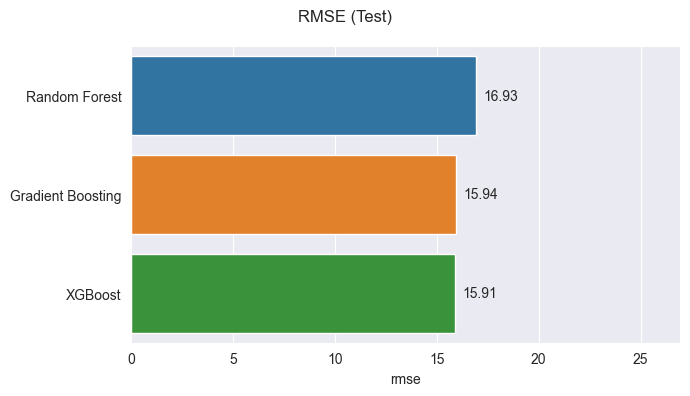

In [38]:
fig = plt.figure(figsize=(7,4))
fig.suptitle("RMSE (Test)")
metrics_plt = sns.barplot(time_metrics.round(2), x='rmse', y='model', orient='h', hue= 'model')
metrics_plt.tick_params(labelsize=10)
for i in range(3):
    metrics_plt.bar_label(metrics_plt.containers[i], size=10, padding=5)
metrics_plt.set(ylabel=None)

plt.xlim(0, max(time_metrics.rmse)+10)
plt.tight_layout()
plt.show()

All models perform similarly in the testing set as well. The lowest scores are given by XGBoost and Random Forests, by a tight margin.

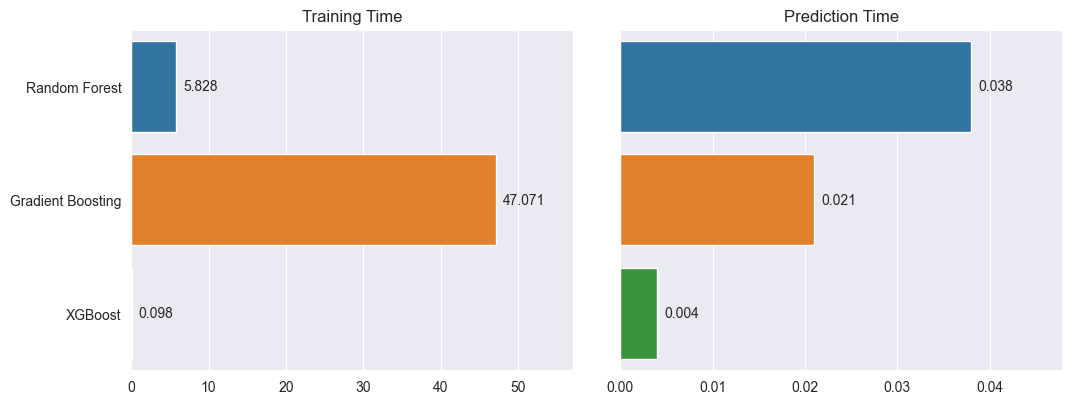

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
fig.tight_layout(w_pad=2.0)

sns.barplot(time_metrics.round(3), x='fit_time', y='model', orient='h', ax=axes[0], hue= 'model')
for i in range(3):
    axes[0].bar_label(axes[0].containers[i], size=10, padding=5)
axes[0].set_xlim(0, max(time_metrics.fit_time)+10)
axes[0].set(xlabel=None, ylabel=None)
axes[0].set_title('Training Time')

sns.barplot(time_metrics.round(3), x='predict_time', y='model', orient='h', ax=axes[1], hue= 'model')
for i in range(3):
    axes[1].bar_label(axes[1].containers[i], size=10, padding=5)
axes[1].set_xlim(0, max(time_metrics.predict_time)+0.01)
axes[1].set(xlabel=None, ylabel=None)
axes[1].set_title('Prediction Time')

plt.show()

By plotting the training and prediction times, we can notice some differences. Random Forests and Gradient Boosting perform the worst in terms of model training time. Additionally, Random Forests have the poorest performance during prediction. Therefore, in my opinion, if we had to select one model, it would be the renowned XGBoost.

$\textbf{Feature Importances} \\$
Feature Importance involves calculating the scores for all input features of a given model. These scores indicate how important each feature is according to the model. A higher score signifies that the specific feature has a greater influence on the model's predictions.

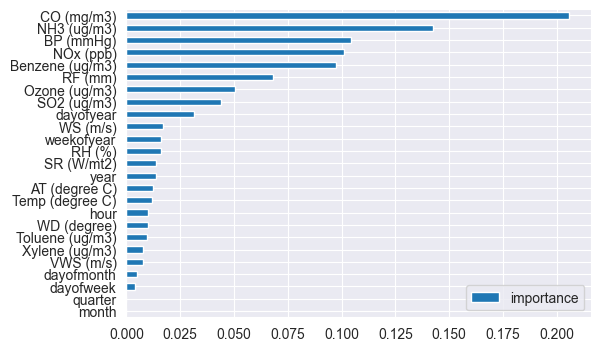

In [41]:
feature_importances_df = pd.DataFrame(data=models['XGBoost'].feature_importances_,
                                      index=models['XGBoost'].feature_names_in_,
                                      columns=['importance'])
feature_importances_df.sort_values('importance').plot(kind='barh', figsize=(6,4)).legend(loc='lower right')

$\textbf{Predictions} \\$

Next, I will have these models make predictions on entirely test data. We will also visually examine the results to gain a better understanding of how XGboost model formulates its predictions. As I can see to make prediction I need 

In [47]:
test_predictions = test_x.copy()
test_target = test_y.copy()

model_name, model = 'XGBoost', models['XGBoost']
test_predictions[f'predict_{model_name}'] = model.predict(test_x)

In [64]:
for i, time_group in enumerate(['1H', '1D', '1W', '1M']):
    print(f'{i}:     {time_group}')
    print(test_y.groupby(pd.Grouper(freq=time_group)).mean())

0:     1H
datetime
2021-11-24 02:00:00    29.803041
2021-11-24 03:00:00    31.353041
2021-11-24 04:00:00    30.819041
2021-11-24 05:00:00    32.153041
2021-11-24 06:00:00    34.419041
                         ...    
2023-03-31 19:00:00    64.663397
2023-03-31 20:00:00    67.953397
2023-03-31 21:00:00    86.546397
2023-03-31 22:00:00    97.047397
2023-03-31 23:00:00    68.505175
Freq: h, Name: PM10 (ug/m3), Length: 11830, dtype: float64
1:     1D
datetime
2021-11-24    45.907495
2021-11-25    74.928124
2021-11-26    80.785791
2021-11-27    84.516291
2021-11-28    93.769055
                ...    
2023-03-27    59.743623
2023-03-28    63.511137
2023-03-29    62.158934
2023-03-30    64.544014
2023-03-31    67.056503
Freq: D, Name: PM10 (ug/m3), Length: 493, dtype: float64
2:     1W
datetime
2021-11-28     76.491078
2021-12-05     83.893170
2021-12-12     55.442896
2021-12-19    103.053556
2021-12-26    115.858962
                 ...    
2023-03-05     97.154228
2023-03-12     94.856696


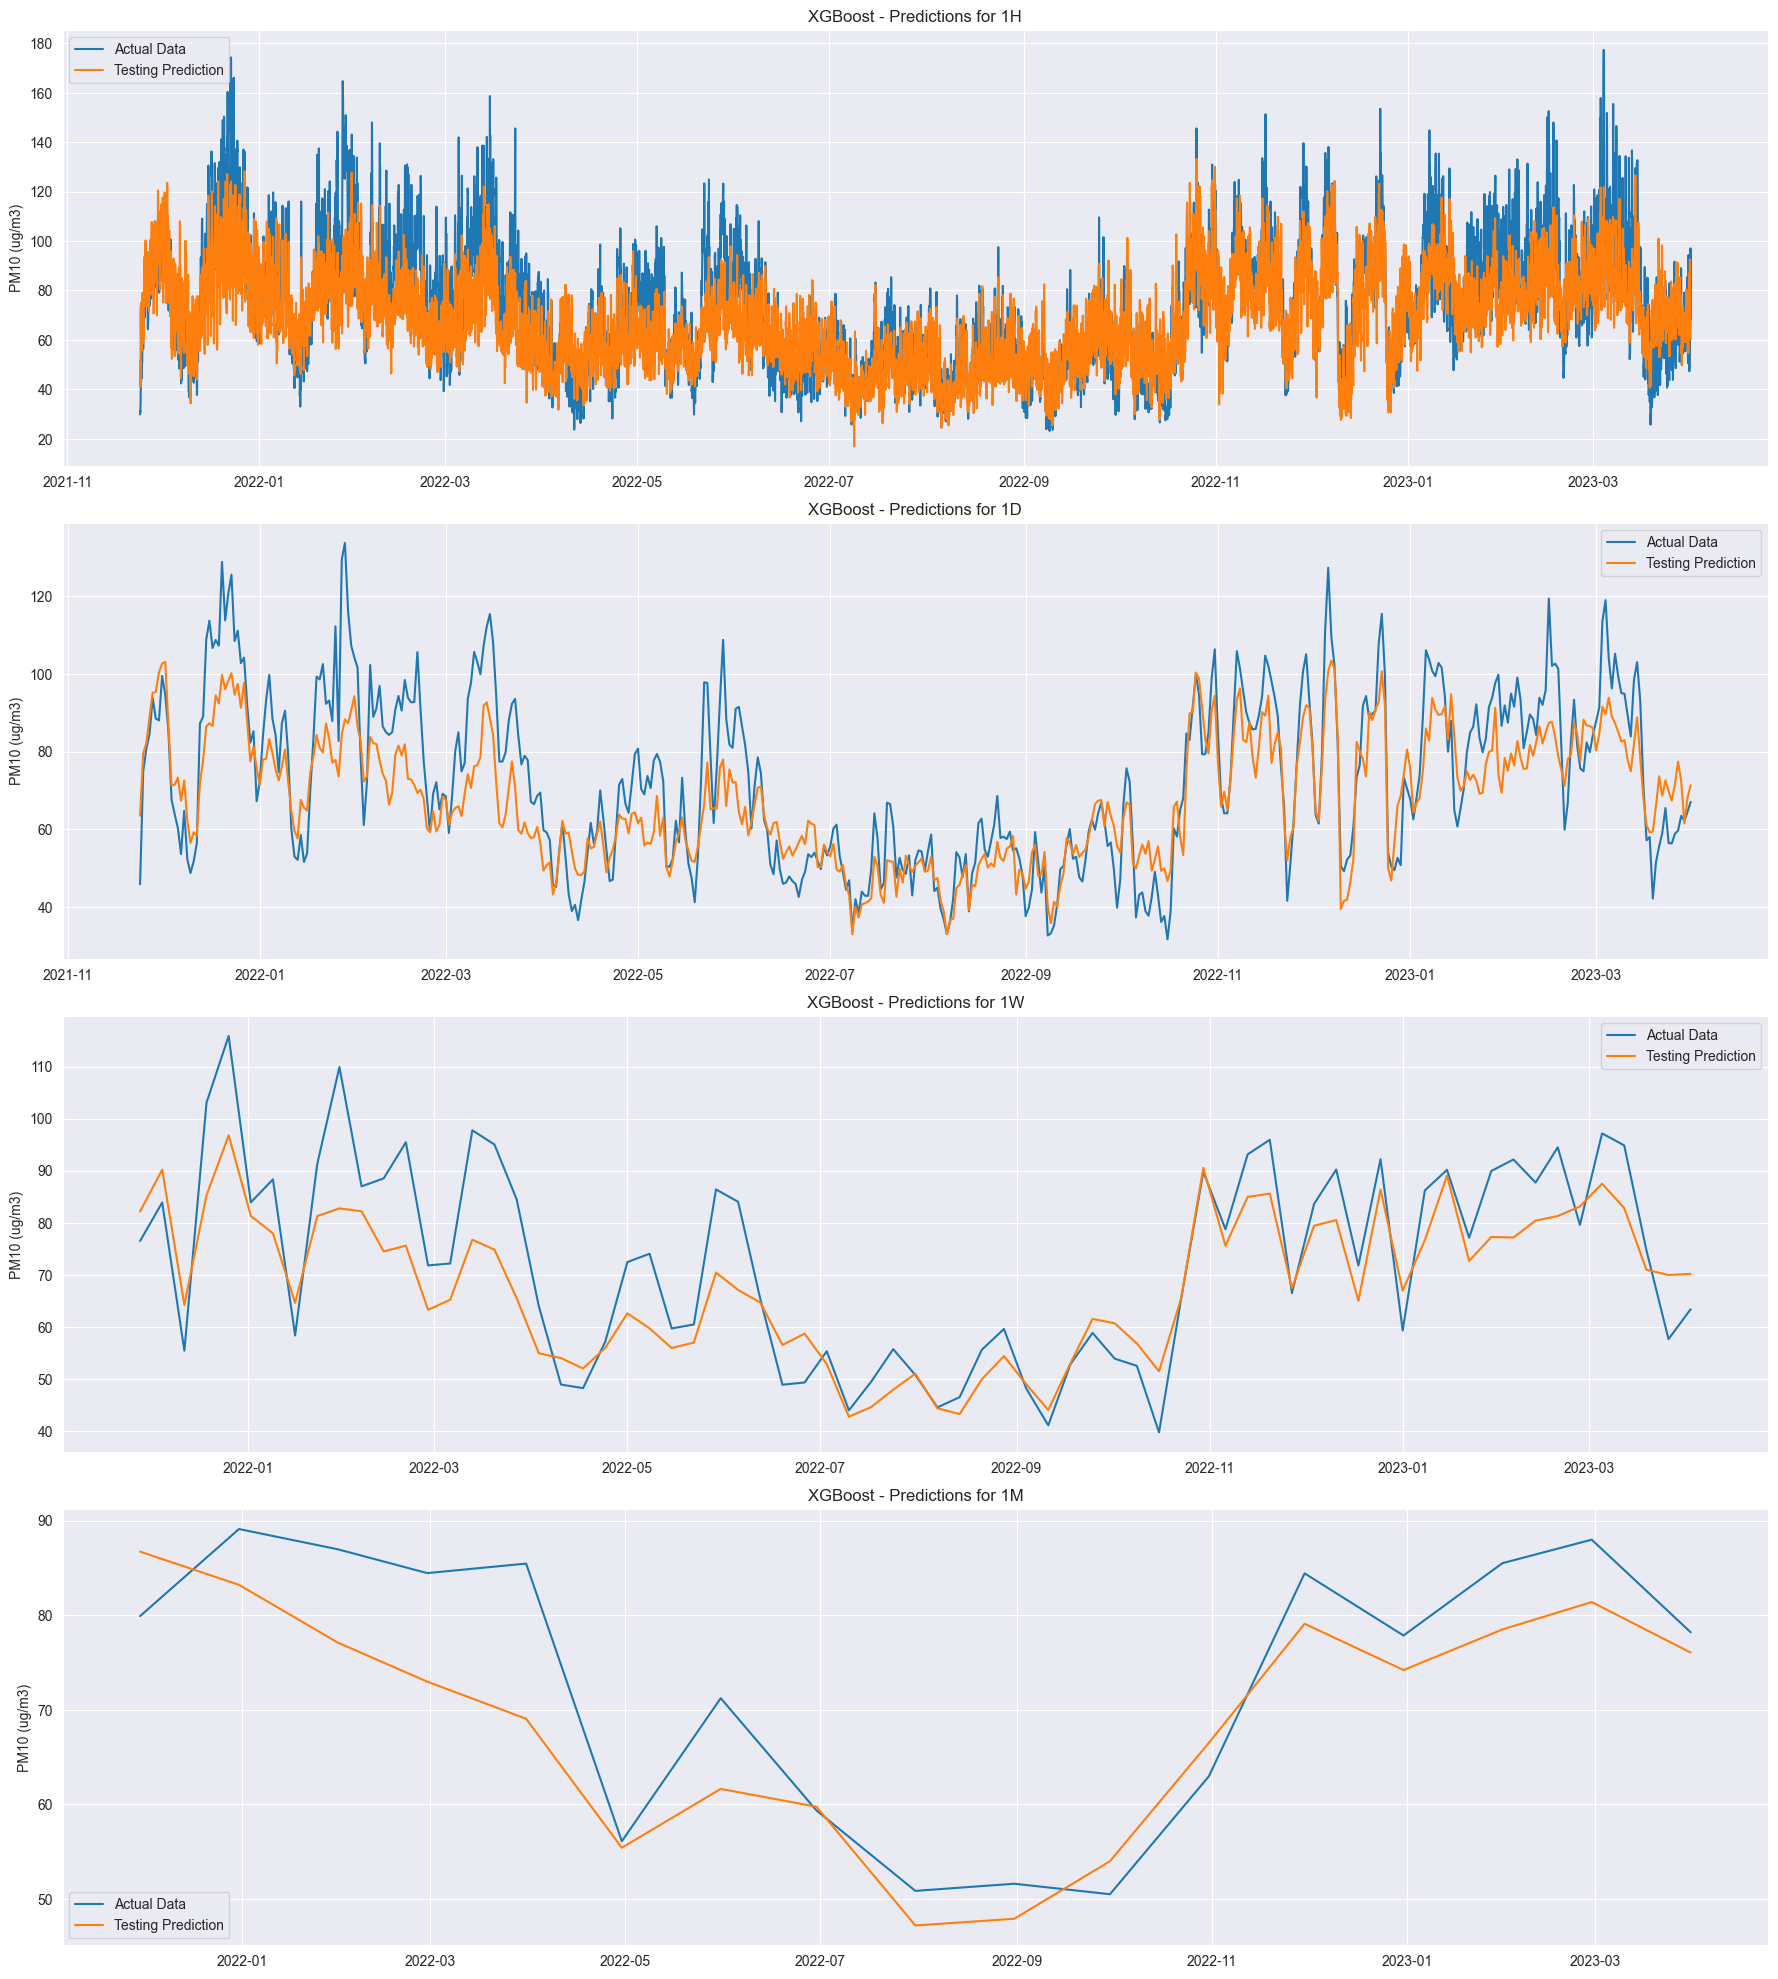

In [65]:
'''
plt.figure(figsize= (18,5))
sns.lineplot(data=test_y, label="Actual Data")
sns.lineplot(data=test_predictions[f'predict_{model_name}'], label="Testing Prediction")
plt.title(f'{model_name} - Predictions')
plt.xlabel = None
    
plt.show()
'''

fig, axes = plt.subplots(4, 1, figsize=(18, 20))
fig.tight_layout(pad=2.0)

for index, time_group in enumerate(['1H', '1D', '1W', '1M']):
    sns.lineplot(data=test_y.groupby(pd.Grouper(freq=time_group)).mean(), label="Actual Data", ax= axes[index])
    sns.lineplot(data=test_predictions[f'predict_{model_name}'].groupby(pd.Grouper(freq=time_group)).mean(), label="Testing Prediction", ax= axes[index])
    axes[index].set_title(f'{model_name} - Predictions for {time_group}')
    axes[index].set(xlabel=None)
    
plt.show()

$\textbf{Model Persistence} \\$
The results indicate that the XGBoost model performed the best for this task. I will save the model as a json file for easy loading.

In [67]:
try:
    os.mkdir('models')
except FileExistsError:
    pass

In [69]:
models['XGBoost'].save_model('models/xgboost_linear_imputation.json')